In [2]:
import pandas as pd
import numpy as np

### Loading Dataset

In [3]:
user_item_matrix = pd.read_csv('user_item_matrix.csv')
user_item_matrix.set_index('userId', inplace=True)
user_item_matrix.columns = user_item_matrix.columns.astype(int)

ratings = pd.read_csv('filtered_ratings.csv')
movie_db = pd.read_csv('movie_db.csv')

In [4]:
print('User-item matrix', user_item_matrix.shape)
print('Ratings', ratings.shape)
print('Movies', movie_db.shape)

User-item matrix (610, 1050)
Ratings (62605, 3)
Movies (1050, 4)


In [5]:
display(user_item_matrix.head(), movie_db.head(), ratings.head())

,1,2,3,5,6,7,10,11,16,17,...,122904,122918,134130,134853,139385,148626,152081,164179,166528,168252
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,4.0,NaN,NaN,NaN,4.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,movieId,title,genres,overview
0,1,Toy Story (1995),"Adventure, Animation, Children, Comedy, Fantasy","adventure, animation, children, comedy, fantas..."
1,2,Jumanji (1995),"Adventure, Children, Fantasy","adventure, children, fantasy, fantasy, magic b..."
2,3,Grumpier Old Men (1995),"Comedy, Romance","comedy, romance, moldy, old, 1995"
3,5,Father of the Bride Part II (1995),Comedy,"comedy, pregnancy, remake, 1995"
4,6,Heat (1995),"Action, Crime, Thriller","action, crime, thriller, 1995"


,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [6]:
display(user_item_matrix.columns, movie_db.columns, ratings.columns)

Index([     1,      2,      3,      5,      6,      7,     10,     11,     16,
           17,
       ...
       122904, 122918, 134130, 134853, 139385, 148626, 152081, 164179, 166528,
       168252],
      dtype='int64', length=1050)

Index(['movieId', 'title', 'genres', 'overview'], dtype='object')

Index(['userId', 'movieId', 'rating'], dtype='object')

In [7]:
rows, cols = user_item_matrix.shape
total_cells = rows * cols
missing_cells = user_item_matrix.isnull().sum().sum()

print(f'Users: {rows}')
print(f'Movies: {cols}')
print(f'Total cells: {total_cells}')
print(f'Missing cells: {missing_cells}')
print(f'Missing percenatge: {missing_cells/total_cells:.2%}')

Users: 610
Movies: 1050
Total cells: 640500
Missing cells: 577898
Missing percenatge: 90.23%


### User-user Collaborative Filtering

In [8]:
def pearson_corr(user_id):
    user_item = user_item_matrix.copy()
    row_means = user_item.mean(axis=1, skipna=True)
    user_item = user_item.subtract(row_means, axis=0)

    target_user_ratings = user_item.loc[user_id]
    corr_data = []

    for index, other_user_ratings in user_item.iterrows():
        if user_id == index:
            continue

        common_ratings = target_user_ratings.notna() & other_user_ratings.notna()

        numerator = (target_user_ratings[common_ratings]
                     * other_user_ratings[common_ratings]).sum()
        denominator = np.sqrt((target_user_ratings[common_ratings] ** 2).sum()) * \
            np.sqrt((other_user_ratings[common_ratings] ** 2).sum())

        if np.isclose(denominator, 0):
            continue

        corr_data.append({
            'user1Id': user_id,
            'user2Id': index,
            'correlation': numerator / denominator
        })

    return pd.DataFrame(corr_data)

In [9]:
def recommend_movies(correlations, n):
    user_id = correlations.iloc[0, 0]
    top_neighbors = correlations.nlargest(n * 5, 'correlation')
    neighbor_ratings = pd.merge(top_neighbors, ratings, left_on='user2Id', right_on='userId')
    avg_movie_ratings = neighbor_ratings.groupby('movieId')['rating'].mean()
    
    target_user_ratings = ratings[ratings['userId'] == user_id]
    movies_watched = target_user_ratings['movieId'].unique()
    recommendable_movies = avg_movie_ratings[~avg_movie_ratings.index.isin(movies_watched)].to_frame()

    top_neighbors_ids = top_neighbors['user2Id']
    correlation_values = top_neighbors['correlation']

    pred_ratings = []

    for idx in recommendable_movies.index:
        mov_ratings = user_item_matrix[idx].loc[top_neighbors_ids]
        
        mult_sum, corr_sum = 0, 0
        for rating, corr_val in zip(mov_ratings, correlation_values):
            if np.isnan(rating): continue
            
            mult_sum += (rating * corr_val)
            corr_sum += corr_val

        if corr_sum > 0:
            predicted_rating = mult_sum / corr_sum
        else:
            print('in')
            predicted_rating = avg_movie_ratings.loc[idx]

        pred_ratings.append(round(predicted_rating, 2))

    recommendable_movies['pred_rating'] = pred_ratings

    top_recommendations = pd.merge(recommendable_movies.nlargest(n, 'pred_rating'), movie_db, on='movieId')
    top_recommendations.drop(['rating', 'overview'], axis=1, inplace=True)

    order = ['movieId', 'title', 'genres', 'pred_rating']
    return top_recommendations.reindex(columns=order)

In [10]:
user_id, n = 214, 10

correlations = pearson_corr(user_id)

top_recommendations = recommend_movies(correlations, n)
top_recommendations

,movieId,title,genres,pred_rating
0,1263,"Deer Hunter, The (1978)","Drama, War",5.0
1,1584,Contact (1997),"Drama, Sci-Fi",5.0
2,2076,Blue Velvet (1986),"Drama, Mystery, Thriller",5.0
3,2078,"Jungle Book, The (1967)","Animation, Children, Comedy, Musical",5.0
4,2150,"Gods Must Be Crazy, The (1980)","Adventure, Comedy",5.0
5,2288,"Thing, The (1982)","Action, Horror, Sci-Fi, Thriller",5.0
6,2321,Pleasantville (1998),"Comedy, Drama, Fantasy",5.0
7,2395,Rushmore (1998),"Comedy, Drama",5.0
8,2716,Ghostbusters (a.k.a. Ghost Busters) (1984),"Action, Comedy, Sci-Fi",5.0
9,2791,Airplane! (1980),Comedy,5.0


### Content-based Filtering

In [11]:
def jaccard_sim(title):
    target_movie = set(str(movie_db[movie_db['title'] == title]['overview']).split(', '))

    result = []
    for _, movie in movie_db.iterrows():
        if movie['title'] == title: continue

        other_movie = set(str(movie['overview']).split(', '))
        jaccard_similarity = len(target_movie.intersection(other_movie)) / len(target_movie.union(other_movie))
        result.append({
            'target_movie': title, 
            'other_movie': movie['title'], 
            'jaccard_sim_score': jaccard_similarity
        })

    return pd.DataFrame(result)

In [12]:
def recommend_similar_movies(similarities, n):
    movies_not_watched = user_item_matrix.columns[user_item_matrix.loc[user_id].isna()]
    movies_not_watched_titles = movie_db[movie_db['movieId'].isin(movies_not_watched)]['title'].to_frame()
    
    recommended_movies = pd.merge(similarities, movies_not_watched_titles, left_on='other_movie', right_on='title')
    recommended_movies = pd.merge(recommended_movies, movie_db)
    
    avg_movie_ratings = ratings.groupby('movieId')['rating'].mean()
    recommended_movies = pd.merge(recommended_movies, avg_movie_ratings, on='movieId')

    recommended_movies = recommended_movies.sort_values(['jaccard_sim_score', 'rating'], ascending=False)

    recommended_movies['jaccard_sim_score'] = round(recommended_movies['jaccard_sim_score'], 2)
    recommended_movies['avg_rating'] = round(recommended_movies['rating'], 2)

    recommended_movies = recommended_movies.reindex(columns=['movieId', 'title', 'genres', 'jaccard_sim_score', 'avg_rating'])

    return recommended_movies.head(n)

In [13]:
name = 'Madagascar (2005)'
similar_movies = recommend_similar_movies(jaccard_sim(name), n)
similar_movies

,movieId,title,genres,jaccard_sim_score,avg_rating
611,3751,Chicken Run (2000),"Animation, Children, Comedy",0.43,3.55
852,45517,Cars (2006),"Animation, Children, Comedy",0.43,3.38
161,745,Wallace & Gromit: A Close Shave (1995),"Animation, Children, Comedy",0.38,3.92
701,5218,Ice Age (2002),"Adventure, Animation, Children, Comedy",0.38,3.69
941,79091,Despicable Me (2010),"Animation, Children, Comedy, Crime",0.38,3.68
224,1148,Wallace & Gromit: The Wrong Trousers (1993),"Animation, Children, Comedy, Crime",0.33,4.04
1012,152081,Zootopia (2016),"Action, Adventure, Animation, Children, Comedy",0.33,3.89
687,4886,"Monsters, Inc. (2001)","Adventure, Animation, Children, Comedy, Fantasy",0.33,3.87
405,2078,"Jungle Book, The (1967)","Animation, Children, Comedy, Musical",0.33,3.83
641,4016,"Emperor's New Groove, The (2000)","Adventure, Animation, Children, Comedy, Fantasy",0.33,3.72


### Data Manipulations

In [14]:
# user_id, movie_id, rating = 2, 475, 4.5

# user_item_matrix[user_id][movie_id] = rating
# ratings.loc[len(ratings)] = [user_id, movie_id, rating]
# ratings['userId'] = ratings['userId'].astype(int)
# ratings['movieId'] = ratings['movieId'].astype(int)

In [15]:
# user_item_matrix.to_csv('user_item_matrix.csv')
# ratings.to_csv('filtered_ratings.csv', index=False)a

In [16]:
# user_item_matrix = pd.read_csv('user_item_matrix.csv')
# user_item_matrix.set_index('userId', inplace=True)
# user_item_matrix.columns = user_item_matrix.columns.astype(int)

# ratings = pd.read_csv('filtered_ratings.csv')

### Stats

In [30]:
user_item_matrix = pd.read_csv('user_item_matrix.csv')
user_item_matrix.set_index('userId', inplace=True)
user_item_matrix.columns = user_item_matrix.columns.astype(int)

ratings = pd.read_csv('filtered_ratings.csv')
movie_db = pd.read_csv('movie_db.csv')

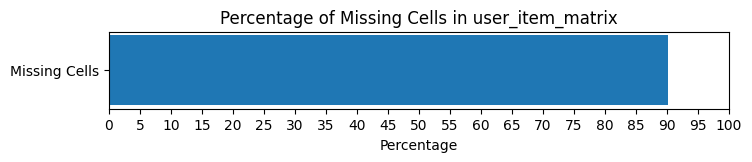

In [55]:
import matplotlib.pyplot as plt

rows, cols = user_item_matrix.shape
total_cells = rows * cols
missing_cells = user_item_matrix.isnull().sum().sum()

plt.figure(figsize=(8, 1))
plt.barh(['Missing Cells'], [(missing_cells/total_cells) * 100])
plt.xlabel('Percentage')
plt.title('Percentage of Missing Cells in user_item_matrix')
plt.xticks(np.arange(0, 101, 5))
plt.savefig('stats/plot1.png', dpi=300)

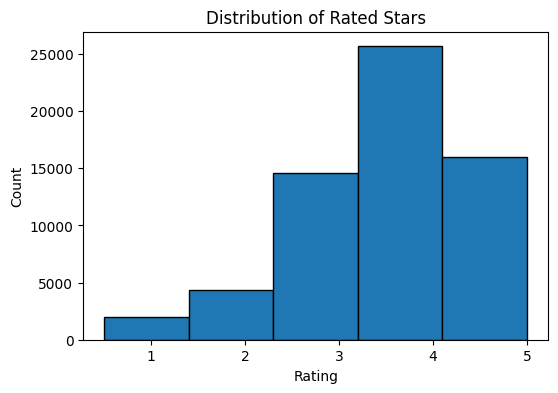

In [40]:
ratings_count = ratings['rating']

# Plot a histogram
plt.figure(figsize=(6, 4))
plt.hist(ratings_count, bins=5, edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Rated Stars')
plt.xticks(range(1, 6))  # Set x-axis tick labels from 1 to 5
plt.show()

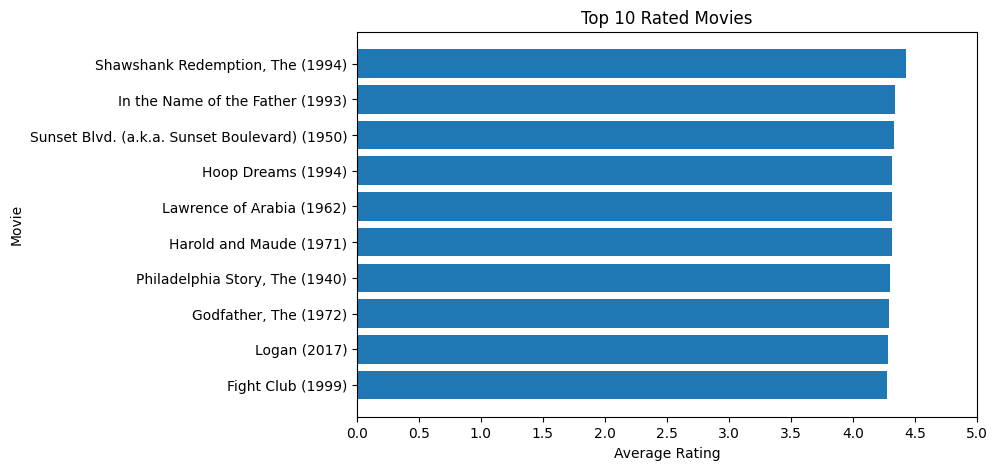

In [50]:
merged_df = pd.merge(ratings, movie_db, on='movieId')

average_ratings = merged_df.groupby(['movieId', 'title'])['rating'].mean().reset_index()

sorted_ratings = average_ratings.sort_values('rating', ascending=False)

top_10_movies = sorted_ratings.head(10)

plt.figure(figsize=(8, 5))
plt.barh(top_10_movies['title'], top_10_movies['rating'])
plt.xlabel('Average Rating')
plt.ylabel('Movie')
plt.title('Top 10 Rated Movies')
plt.xticks(np.arange(0, 5.5, 0.5))
plt.gca().invert_yaxis() 
plt.show()

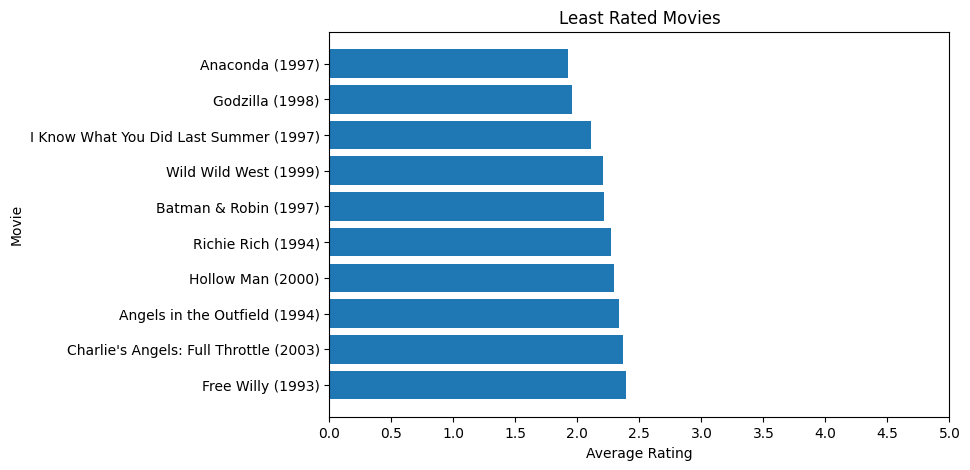

In [52]:
merged_df = pd.merge(ratings, movie_db, on='movieId')

average_ratings = merged_df.groupby(['movieId', 'title'])['rating'].mean().reset_index()

sorted_ratings = average_ratings.sort_values('rating', ascending=False)

top_10_movies = sorted_ratings.tail(10)

plt.figure(figsize=(8, 5))
plt.barh(top_10_movies['title'], top_10_movies['rating'])
plt.xlabel('Average Rating')
plt.ylabel('Movie')
plt.title('Least Rated Movies')
plt.xticks(np.arange(0, 5.5, 0.5))
plt.show()

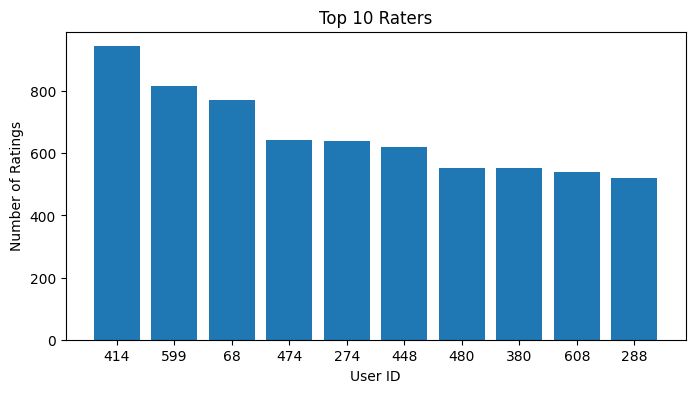

In [48]:
user_ratings_count = ratings['userId'].value_counts()
sorted_raters = user_ratings_count.sort_values(ascending=False)
top_10_raters = sorted_raters.head(10)

plt.figure(figsize=(8, 4))
plt.bar([str(user) for user in top_10_raters.index], top_10_raters.values)
plt.xlabel('User ID')
plt.ylabel('Number of Ratings')
plt.title('Top 10 Raters')
plt.show()